# Phase diagram exploration : coarse grained theory

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter compatibility
from itertools import product
from scipy.optimize import root_scalar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# --- Parameters ---
delta = 0.1
k_s = 0.02
b = 0.005  # constant

# Define the ODE function
def dy_dt(y, delta, x1p, x1n, k_s):
    return y/(1 + y) - delta * y + 0.017 * x1p - (y * (b + 0.017 *x1n)) / (k_s + y)

# --- Parameter grid for sweep ---
nb_of_points = 100
x1p_values = np.linspace(0, 10, nb_of_points)  # production rate (vertical axis in our plot)
x1n_values = np.linspace(0, 10, nb_of_points)   # removal rate (horizontal axis)

# Bounds for y (concentration)
y_min_bound = 0
y_max_bound = 10

# This threshold defines the upper limit of the "low concentration branch."
# For many systems, the "physically acceptable" branch (if it exists in a bistable region)
# is the one with y << 1. In regions where the system is truly monostable ON,
# this low bracket will fail and we then accept the unique (higher) fixed point.
low_branch_thresh = 0.5

all_results = []  # To record (x1p, x1n, fp)

# Loop with progress bar
for x1p, x1n in tqdm(product(x1p_values, x1n_values),
                     total=len(x1p_values)*len(x1n_values),
                     desc="Calculating fixed points"):
    fp_value = np.nan  # default if nothing acceptable is found

    # --- First, try to force the low (physically acceptable) branch ---
    found_low = False
    try:
        # Attempt a bracketing in [0, low_branch_thresh] with brentq.
        sol_low = root_scalar(dy_dt, args=(delta, x1p, x1n, k_s),
                              bracket=[y_min_bound, low_branch_thresh],
                              method='brentq')
        if sol_low.converged:
            fp_value = sol_low.root
            found_low = True
    except ValueError:
        # Likely no sign change in [0, low_branch_thresh]
        found_low = False

    # --- If low branch not found, try the multi–guess approach ---
    if not found_low:
        fixed_points = []
        for y_guess in [y_min_bound, 1, 5, y_max_bound]:
            try:
                sol = root_scalar(dy_dt, args=(delta, x1p, x1n, k_s),
                                  method='secant', x0=y_guess)
                # Only consider those fixed points that fall in the acceptable range.
                if sol.converged and y_min_bound <= sol.root <= y_max_bound:
                    fixed_points.append(sol.root)
            except Exception:
                continue
        if fixed_points:
            # Choose the lowest among those found.
            fp_value = min(fixed_points)
        else:
            fp_value = np.nan

    all_results.append((x1p, x1n, fp_value))

# Convert the results to a NumPy array for easier handling:
all_results = np.array(all_results, dtype=np.float64)
# Columns: 0 -> x1p, 1 -> x1n, 2 -> the chosen fixed point (y)
x1p_plot = all_results[:, 0]
x1n_plot = all_results[:, 1]
fp_values = all_results[:, 2]  # these are our "lowest" fixed point values



Calculating fixed points:   0%|          | 0/10000 [00:00<?, ?it/s]

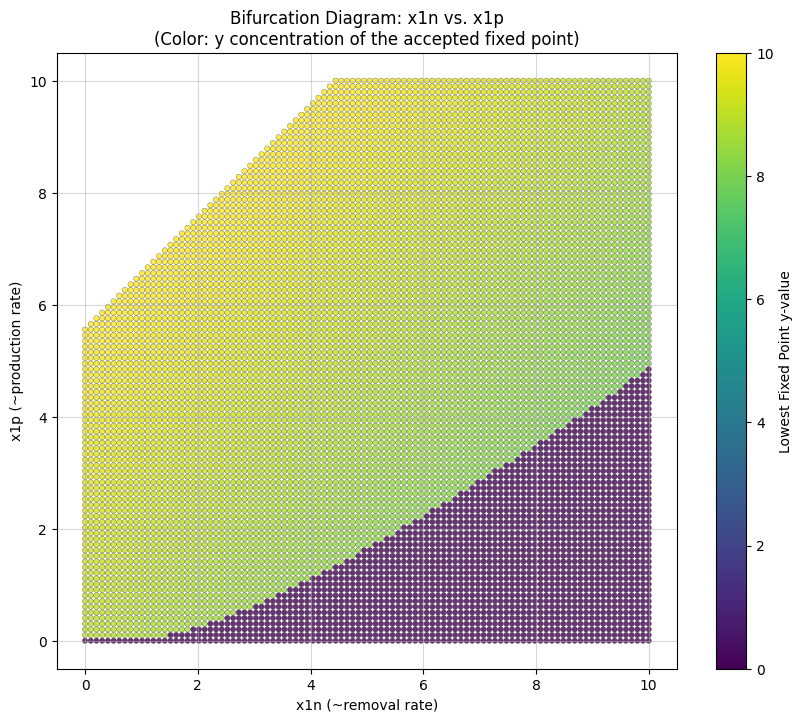

In [4]:
# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 8))
# Use scatter and let the color be determined by the fixed point value.
# (Points where no acceptable fixed point was found remain transparent.)
sc = ax.scatter(x1n_plot, x1p_plot, c=fp_values, cmap='viridis', s=15,
                vmin=0, vmax=y_max_bound, edgecolors='k', linewidth=0.2, alpha=0.8)

# Create a ScalarMappable for the colorbar.
norm = mcolors.Normalize(vmin=0, vmax=y_max_bound)
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Attach the colorbar to the axis.
cbar = fig.colorbar(sm, ax=ax, label="Lowest Fixed Point y-value")

ax.set_xlabel("x1n (~removal rate)")
ax.set_ylabel("x1p (~production rate)")
ax.set_title("Bifurcation Diagram: x1n vs. x1p\n(Color: y concentration of the accepted fixed point)")
ax.grid(alpha=0.5)

# Optional annotations
labels = [
    {"text": "System off (y≈0)", "xy": (0.75, 0.75), "xytext": (0.75, 0.80)},
    {"text": "System ON (y>0)", "xy": (0.8, 0.2), "xytext": (0.8, 0.3)},
]


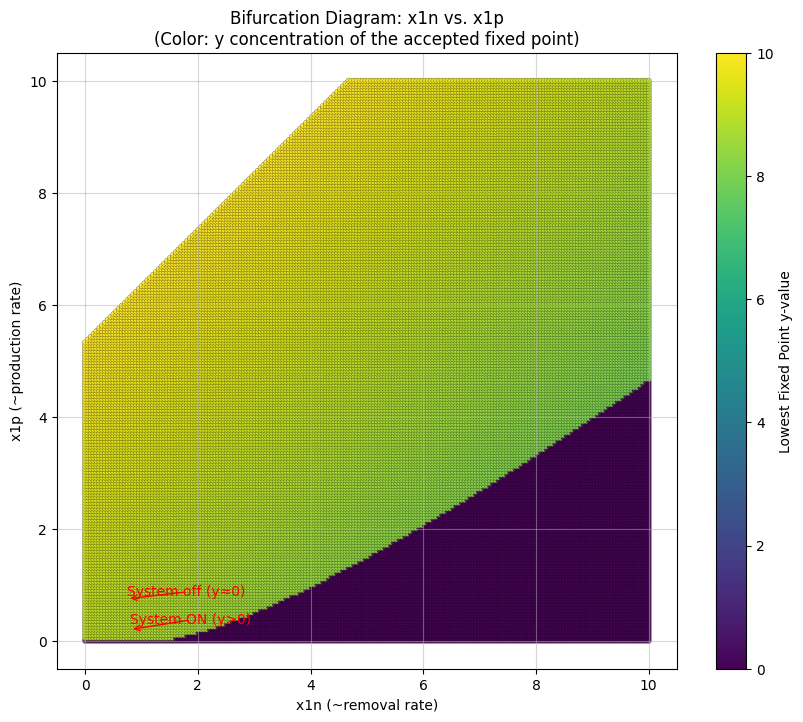

I understand now why there is an upper branch : it is because I asked the algo to always choose the lowest fp, en partant du principe que on commence à des valeurs faibles de x1p,x1n (bas gauche). Mais plus on augmente x1p,x1n, plus la concentration en y augmente, donc à un moment, le FP le plus proche n'est plus 0FF mais le ON. On ne doit donc pas considerer le FP le plus bas, mais le FP le plus proche. FINAL : peut importe de quelle valeur on part, tout ce qui compte est dans quel bassin d'attraction on est, le off ou le on.
Finally, we discard the upper branch by physical argument, because it leads to negative concentrations.

In the following code, when the fixed point is ambiguous, instead of solving with fp, we directly integrate the equation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter compatibility
from itertools import product
from scipy.integrate import solve_ivp
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# --- Parameters ---
delta = 0.1
k_s = 0.02
b = 0.005  # constant

# Define the ODE function. Note that we include the time argument (needed by solve_ivp)
def dy_dt(t, y, delta, x1p, x1n, k_s):
    return y/(1 + y) - delta * y + 0.017 * x1p - (y * (b + 0.017 * x1n)) / (k_s + y)

# A helper function to integrate the ODE until (approximately) steady state.
def integrate_ode(x1p, x1n, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(dy_dt, t_span, [y0],
                    args=(delta, x1p, x1n, k_s),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1]

# --- Parameter grid for sweep ---
nb_of_points = 50
x1p_values = np.linspace(0, 10, nb_of_points)  # production rate (vertical axis)
x1n_values = np.linspace(0, 10, nb_of_points)  # removal rate (horizontal axis)

# (Informational) bounds for y. Not enforced but useful for plotting.
y_min_bound = 0
y_max_bound = 10

# Threshold for what we consider the off state (a value near 0)
off_thresh = 0.1
# Additional parameter: when removal is high we force the off branch.
x1n_thresh = 6.0  # adjust this threshold as needed

all_results = []  # To record (x1p, x1n, chosen fixed point)

# Define integration time spans for both probes.
t_span_off = (0, 100)
t_span_on  = (0, 100)

# Loop with progress bar
for x1p, x1n in tqdm(product(x1p_values, x1n_values),
                     total=len(x1p_values)*len(x1n_values),
                     desc="Calculating basins..."):
    # Integration from a very low initial condition (off probe)
    y_off_candidate = integrate_ode(x1p, x1n, y0=1e-6, t_span=t_span_off)
    # Integration from a higher initial condition (on probe)
    y_on_candidate  = integrate_ode(x1p, x1n, y0=8.0, t_span=t_span_on)

    # Decision logic:
    # If removal is high then simply trust the off candidate (it should yield y ~ 0).
    if x1n >= x1n_thresh:
        chosen_fp = y_off_candidate
    else:
        # Otherwise, if the off candidate is sufficiently low, take it (OFF is available).
        if y_off_candidate < off_thresh:
            chosen_fp = y_off_candidate
        else:
            # In regions where the off candidate is not very low, choose the high–initial condition result.
            chosen_fp = y_on_candidate

    # Clip the result to the defined bounds.
    chosen_fp = np.clip(chosen_fp, y_min_bound, y_max_bound)

    all_results.append((x1p, x1n, chosen_fp))

# Convert the results to a NumPy array for easier handling.
all_results = np.array(all_results, dtype=np.float64)
# Columns: 0 -> x1p, 1 -> x1n, 2 -> chosen fixed point (y)
x1p_plot = all_results[:, 0]
x1n_plot = all_results[:, 1]
fp_values = all_results[:, 2]




Calculating basins...:   0%|          | 0/2500 [00:00<?, ?it/s]

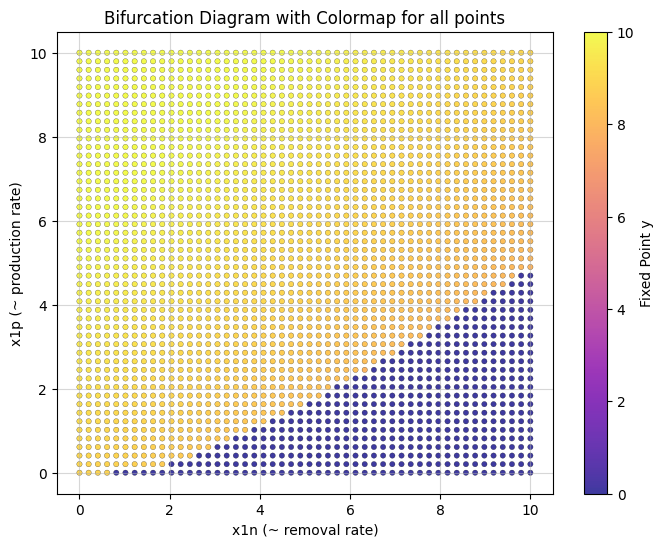

In [2]:
# --- Plotting ---
plt.figure(figsize=(8,6))

# Plot all points using a colormap.
sc = plt.scatter(x1n_plot, x1p_plot,
                 c=fp_values,
                 cmap='plasma', vmin=0, vmax=y_max_bound,
                 s=15, alpha=0.8,
                 edgecolors='k', linewidth=0.2)

cbar = plt.colorbar(sc, label="Fixed Point y")
plt.xlabel("x1n (~ removal rate)")
plt.ylabel("x1p (~ production rate)")
plt.title("Bifurcation Diagram with Colormap for all points")
plt.grid(alpha=0.5)
plt.show()

# Frontier of classification

Versatile linear classification requires negative weights. We opted
for a strategy of induced inhibition, in which an input produces a
drain template13, which in turn suppresses the replication of the signal
strand—implementing a negative weight (model

Le graphe suivant est le profil de frontière dans l'espace classifié, à ne pas confondre avec la fonction d'activation !!


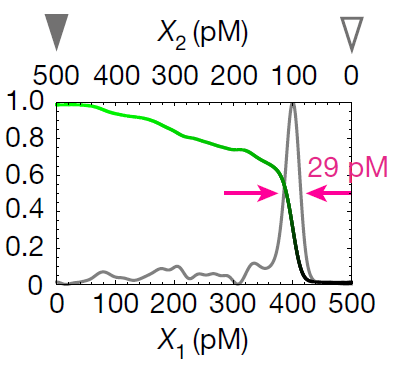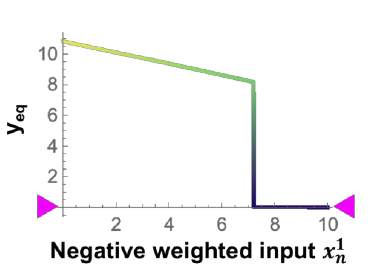

The full-width at half-maximum (FWHM) of the derivative is a proxy for the decision margin of the classifier,that is, **the distance between unambiguously OFF and ON
regions**. In the model, the FWHM=0, direct consequence of the bistability switcher : we switch from OFF to ON as soon as the bifurcation point appears (smallest stable and unstable fp collapse). Then, wathever the fluo concentration is (ie y*), there is only the non-zero stable FP. An abrupt frontier is great as it speaks for perfect classification. Experimentally although, this is not exactly the case.

Le graphe suivant c'est le résultat expérimental et micro de l'approche théorique coarse grained qu'on a fait. DAns les petits encadrés, c'est la convergence vers le steady state, steady state défini si on se trouve dans tel ou tel bassin d'attraction.

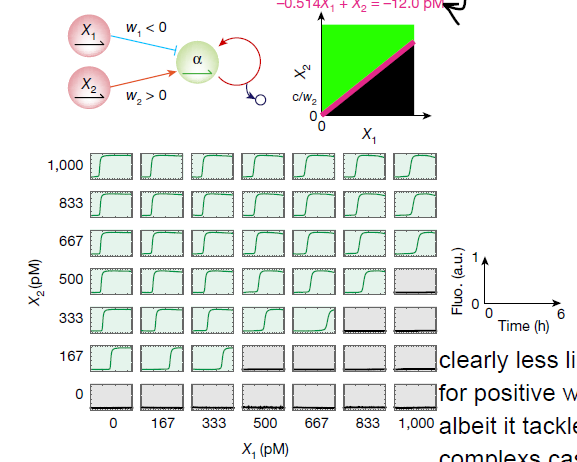

Assuming a linear fit (as it should be a linear lcassifier),  gives us the following confusion matrix. Not incredible results as indeed the frontier is not a line yet a curve.

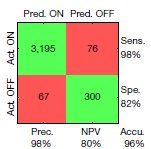

# Activation function

The threshold activation function and the possibility to control the
bias (c) is estimated by measuring the concentration of α required to trigger the
amplification reaction at given (because positive weight so cst dT) drain template (dTα) concentrations

La forme de la fonction d'activation ne dépend pas de N et P, ie de la config positive weight ou negative weight, puisque seule l'équation cubique en y définit le paysage de l'espace des configurations.

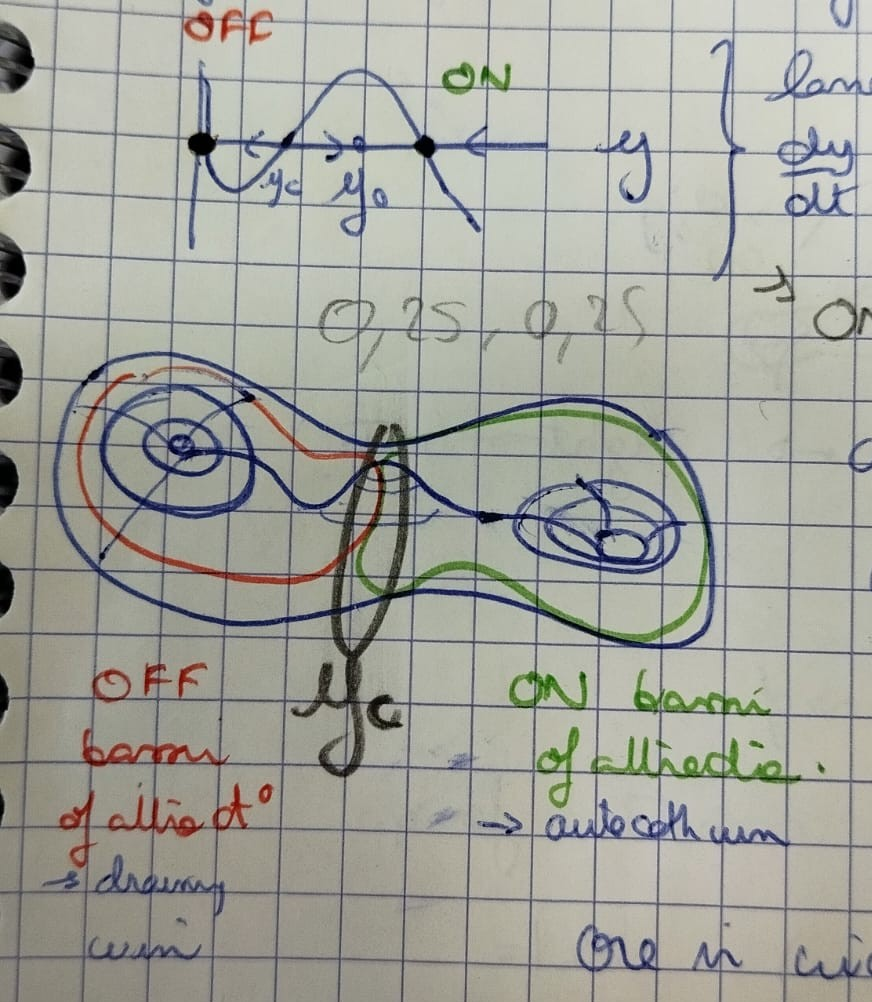

L'état stationnaire dépend donc de la positiion initiale de la concentration $\alpha_0$ à t=0, dans quel bassin on se trouve. NON C'EST JUSTE SAVOIR SI LAUTOAMPLIFICATION OU LANHILATION  (CORRIGER LA SUITE) Pour les positive weight, c'est une competition entre dT (constant) et rT pour l'accès à alpha. En conséquence, $\alpha_c$  est fixé et ne dépend que de dT. Pour les négatives weight, c'est une compétition entre dTn(t)+dT et rT pour l'accès à alpha. En conséuqence, $\alpha_c$  varie dans le temps.
Le biais, inclu dans $\alpha_c$, ne fait que shifter le seuil d'activation.



La forme de la fonction d'activation est obtenue experimentallement, et n'est  fonction que de la nature de la cinétique chimique. Pour obtenir une fonction d'activation moins ambigue (pente plus raide) sans toutefois viser le créneau (qui rendrait tout apprentissage impossible), on pourrai tenter une autre reaction de fluorescence (augmentation de la fréquence de fluo), ou augmenter la probabilité de capture  en augmentant les especes en solution. Cette dernière solution ne ferait toutefois qu'augmenter le bruit, qui nous faudrait alors caracteriser.
